# Zasoby

* https://cloud.google.com/bigquery/docs/generate-text-tutorial

* https://cloud.google.com/bigquery/docs/e2e-journey

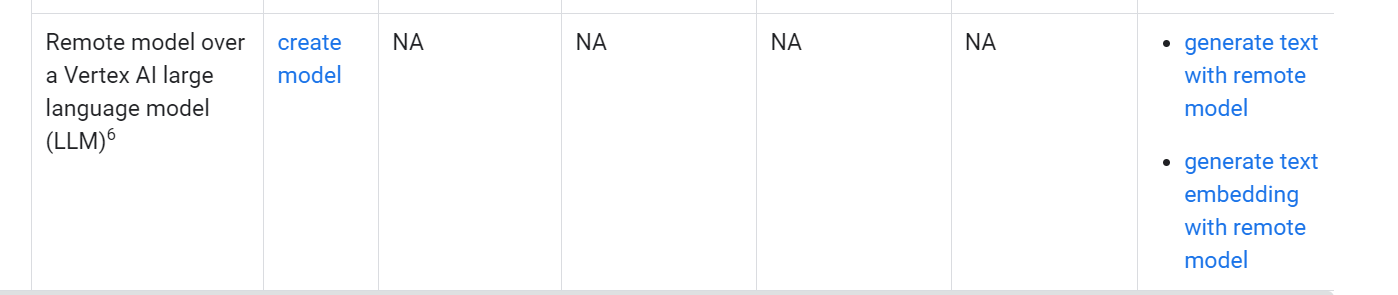

#Cele

* W tym samouczku pokazano, jak utworzyć model zdalny oparty na `text-bison` modelu dużego języka, a następnie użyć tego modelu wraz z `ML.GENERATE_TEXT` funkcją do wykonania kilku zadań związanych z generowaniem tekstu. W tym samouczku używana jest `bigquery-public-data.imdb.review` stabela publiczna.

#Połączenie z Vertex AI (Krok 1)

In [ ]:
bq mk --connection --location=US --project_id=prj-ecom-p-ad-server-1077 \
    --connection_type=CLOUD_RESOURCE biglake

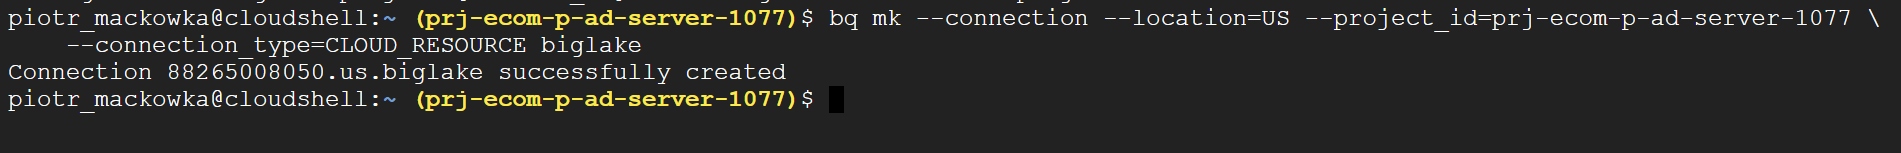

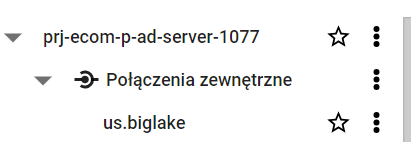

* Pobierz i skopiuj `identyfikator konta usługi`, ponieważ będziesz go potrzebować w późniejszym kroku

In [ ]:
bq show --connection prj-ecom-p-ad-server-1077.us.biglake

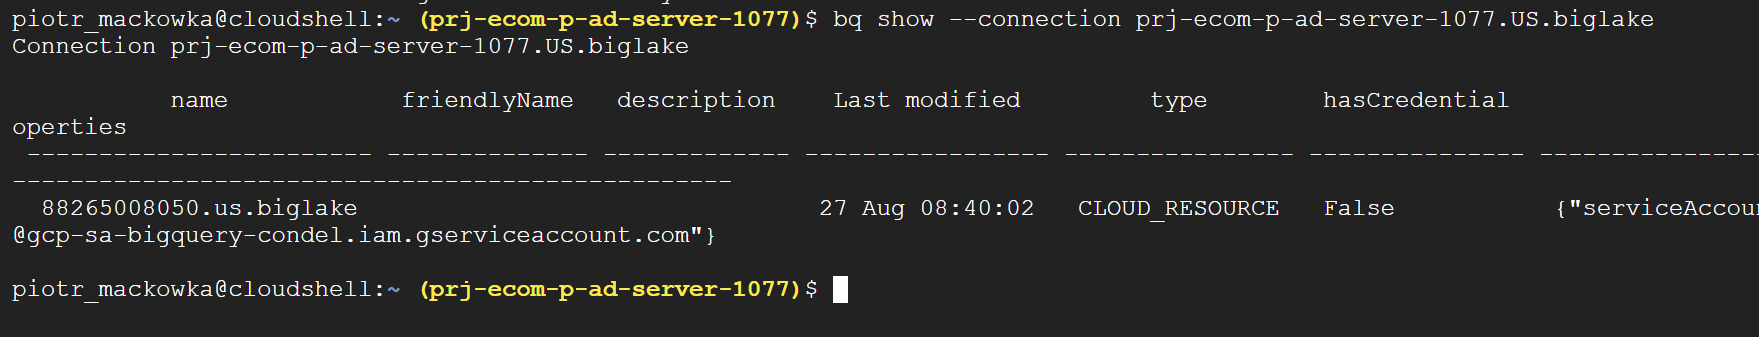

In [ ]:
bqcx-88265008050-clvq@gcp-sa-bigquery-condel.iam.gserviceaccount.com

* Identyfikator jest również dostępny w konfiguracji połączenia.

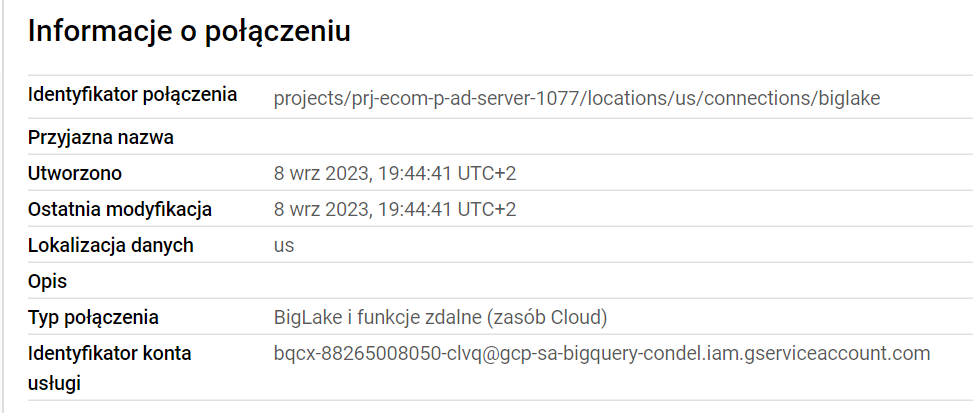

#Przyznaj uprawnienia kontu usługi połączenia (Krok 2)

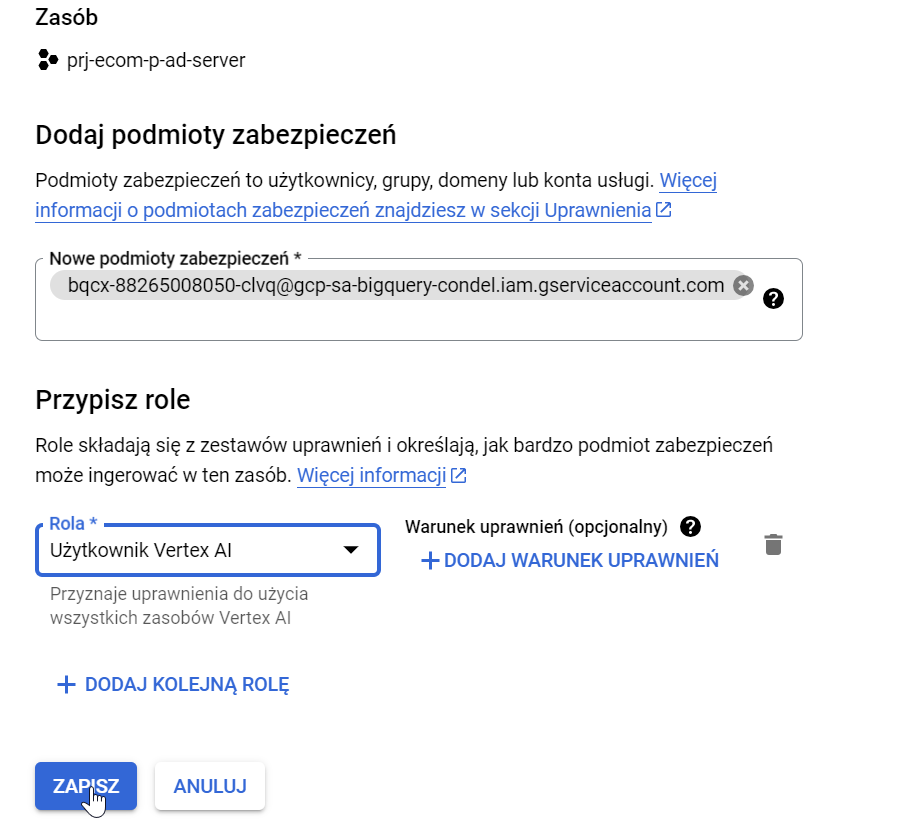

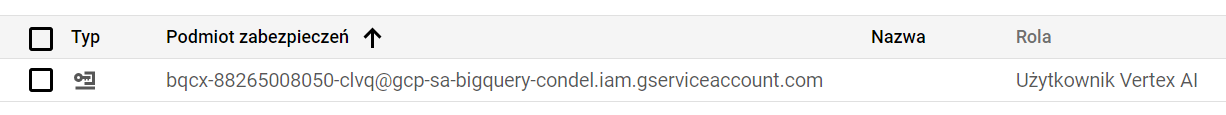

#Utwórz model zdalny (Krok 3)

* Utwórz model zdalny reprezentujący hostowany model wielojęzyczny (LLM) firmy Vertex AI

In [ ]:
%%bigquery

CREATE OR REPLACE MODEL pmackowka_us.model_llm_0061
  REMOTE WITH CONNECTION `us.biglake`
  OPTIONS (remote_service_type = 'CLOUD_AI_LARGE_LANGUAGE_MODEL_V1');

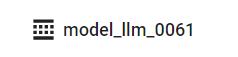

#Wykonaj wyodrębnianie słów kluczowych (Krok 4)

* Wykonaj wyodrębnianie słów kluczowych z recenzji filmów IMDB za pomocą zdalnego modelu i `ML.GENERATE_TEXT` funkcji.

* https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-generate-text

* Extract the key words from the text below = Wyodrębnij słowa kluczowe z poniższego tekstu

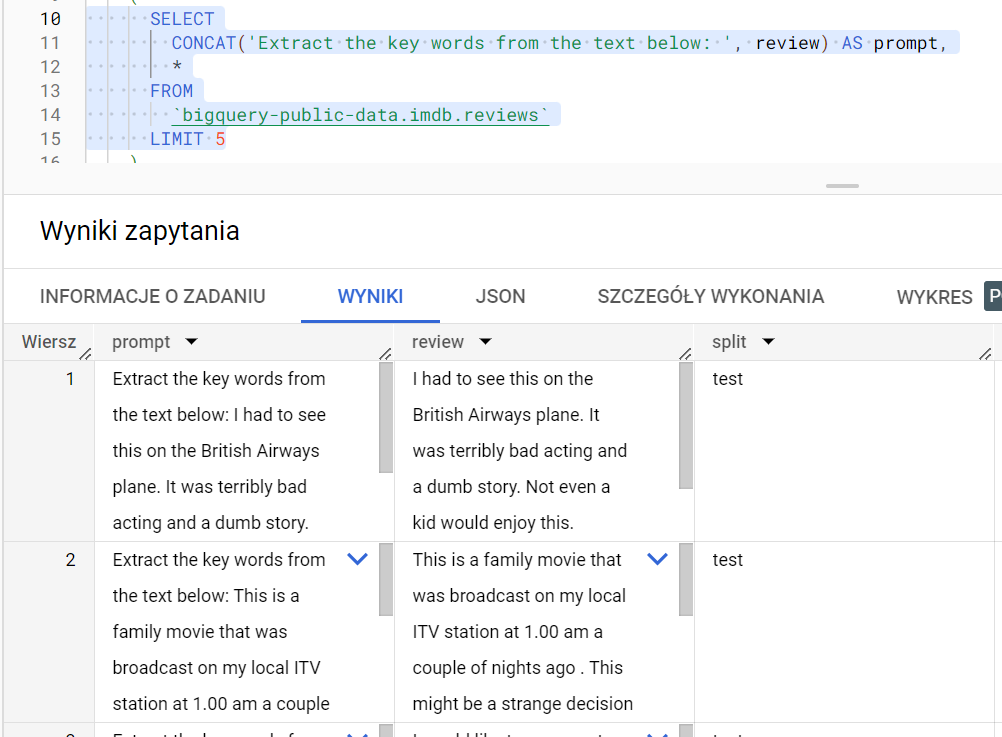

In [ ]:
%%bigquery

SELECT
  ml_generate_text_result['predictions'][0]['content'] AS generated_text,
  ml_generate_text_result['predictions'][0]['safetyAttributes'] AS safety_attributes,
  * EXCEPT (ml_generate_text_result)
FROM
  ML.GENERATE_TEXT(MODEL `pmackowka_us.model_llm_0061`,
    (
      SELECT
        CONCAT('Extract the key words from the text below: ', review) AS prompt,
        *
      FROM
        `bigquery-public-data.imdb.reviews`
      LIMIT 5
    ),
    STRUCT(
      0.2 AS temperature,
      100 AS max_output_tokens));

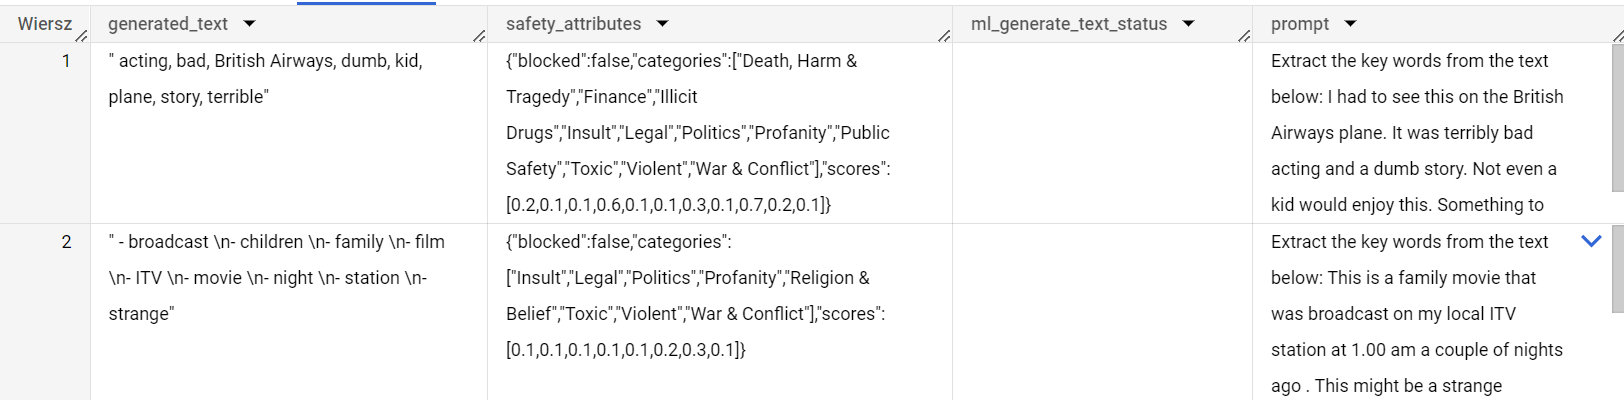

* `generated_text`: wygenerowany tekst.

* `safety_attributes`: atrybuty bezpieczeństwa wraz z informacją, czy treść jest blokowana ze względu na jedną z kategorii blokowania. Aby uzyskać więcej informacji na temat atrybutów bezpieczeństwa, zobacz `Vertex PaLM API`.

* `Interfejs PaLM API` ma funkcję oceny atrybutów bezpieczeństwa, która pomaga klientom testować filtry bezpieczeństwa Google i definiować progi ufności odpowiednie dla ich przypadku użycia i działalności.

* Z każdym atrybutem bezpieczeństwa powiązany jest wskaźnik pewności w przedziale od 0,0 do 1,0, zaokrąglony do jednego miejsca po przecinku, odzwierciedlający prawdopodobieństwo, że dane wejściowe lub odpowiedź należą do danej kategorii.

* https://cloud.google.com/vertex-ai/docs/generative-ai/learn/responsible-ai#safety_filters_and_attributes

* `ml_generate_text_status`: status odpowiedzi API dla odpowiedniego wiersza. Jeśli operacja się powiodła, ta wartość jest pusta.

* `prompt`: zachęta używana do analizy tonacji.

#Wykonaj wyodrębnianie słów kluczowych (Krok 4)

* Opcjonalnie: zamiast ręcznie analizować kod JSON zwrócony przez funkcję, jak to zrobiono w poprzednim kroku, użyj argumentu, `flatten_json_output`, aby zwrócić wygenerowany tekst i atrybuty bezpieczeństwa w oddzielnych kolumnach.

In [ ]:
%%bigquery

SELECT
  *
FROM
  ML.GENERATE_TEXT(
    MODEL `pmackowka_us.model_llm_0061`,
    (
      SELECT
        CONCAT('Extract the key words from the text below: ', review) AS prompt,
        *
      FROM
        `bigquery-public-data.imdb.reviews`
      LIMIT 5
    ),
    STRUCT(
      0.2 AS temperature,
      100 AS max_output_tokens,
      TRUE AS flatten_json_output));

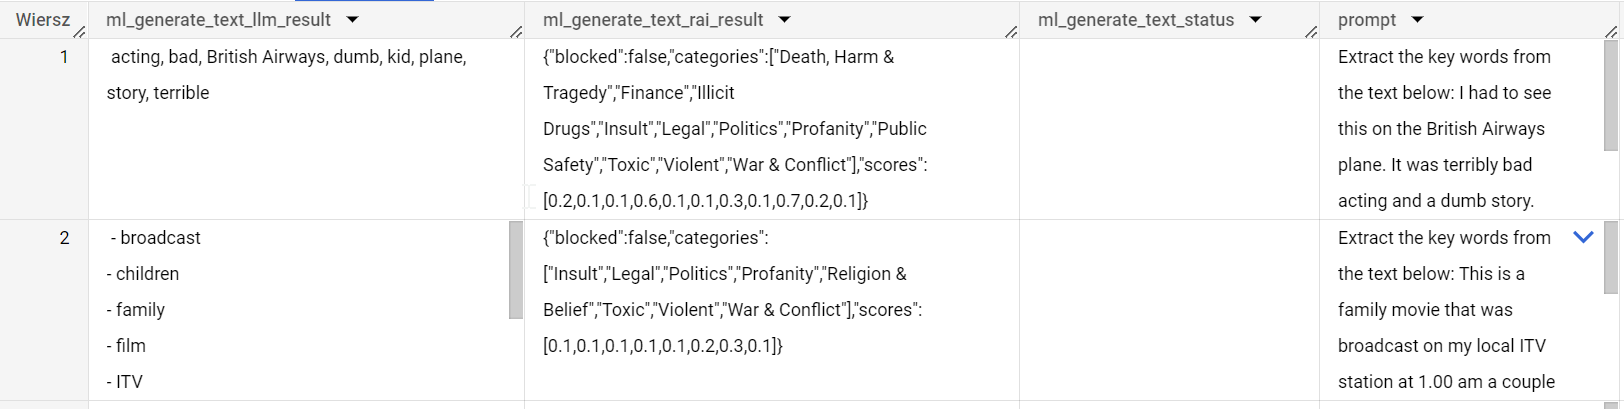

* `ml_generate_text_llm_result`: wygenerowany tekst.
* `ml_generate_text_rai_result`: atrybuty bezpieczeństwa wraz z informacją, czy treść jest blokowana ze względu na jedną z kategorii blokowania. Aby uzyskać więcej informacji na temat atrybutów bezpieczeństwa, zobacz Vertex PaLM API.
* `ml_generate_text_status`: status odpowiedzi API dla odpowiedniego wiersza. Jeśli operacja się powiodła, ta wartość jest pusta.
* `prompt`: zachęta używana do wyodrębniania słów kluczowych.

#Przeprowadź analizę nastrojów (Krok 5)

* Przeprowadź analizę nastrojów w recenzjach filmów IMDB, korzystając ze zdalnego modelu i `ML.GENERATE_TEXT` funkcji

In [ ]:
%%bigquery

SELECT
  ml_generate_text_result['predictions'][0]['content'] AS generated_text,
  ml_generate_text_result['predictions'][0]['safetyAttributes'] AS safety_attributes,
  * EXCEPT (ml_generate_text_result)
FROM
  ML.GENERATE_TEXT(MODEL `pmackowka_us.model_llm_0061`,
    (
      SELECT
        CONCAT('perform sentiment analysis on the following text, return one the following categories: positive, negative: ', review) AS prompt,
        *
      FROM
        `bigquery-public-data.imdb.reviews`
      LIMIT 5
    ),
    STRUCT(
      0.2 AS temperature,
      100 AS max_output_tokens));

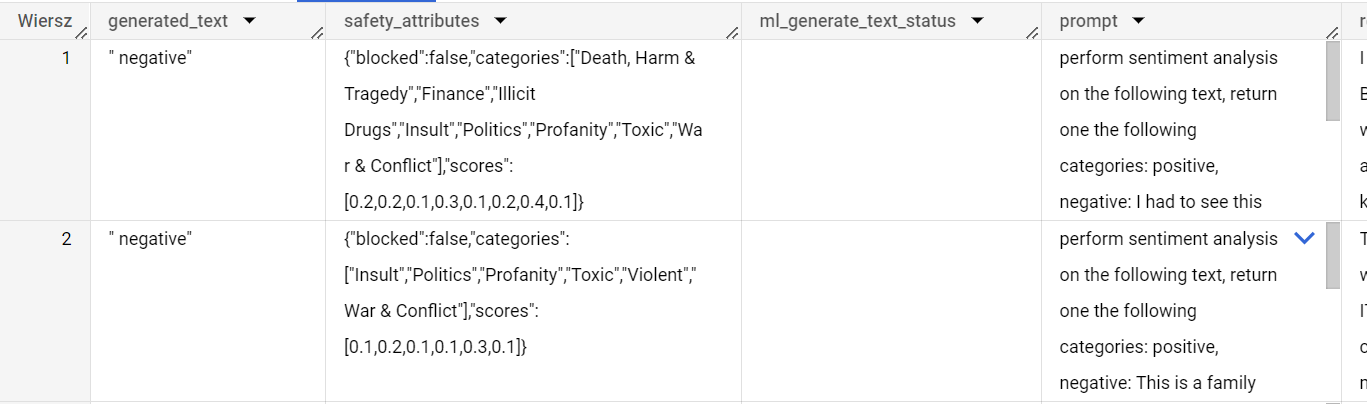